In [13]:
# zeppalin interop with mapplot
import StringIO
def show(p):
    img = StringIO.StringIO()
    p.savefig(img, format='svg')
    img.seek(0)
    print "%html <div style='width:600px'>" + img.buf + "</div>"
    #print "<div style='width:600px'>" + img.buf + "</div>"

%html <div style='width:600px'><?xml version="1.0" encoding="utf-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="432pt" version="1.1" viewBox="0 0 576 432" width="576pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="
M0 432
L576 432
L576 0
L0 0
z
" style="fill:#ffffff;"/>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="
M72 388.8
L518.4 388.8
L518.4 43.2
L72 43.2
z
" style="fill:#ffffff;"/>
   </g>
   <g id="patch_3">
    <path clip-path="url(#p7ff5b81e1d)" d="
M109.2 388.8
L142.68 388.8
L142.68 43.2
L109.2 43.2
z
" style="fill:#0000ff;stroke:#000000;"/>
   </g>
   <g id="patch_4">
    <path clip-path="url(#p7ff5b81e1d)" d="
M142.68 388.8
L176.16 388.8
L

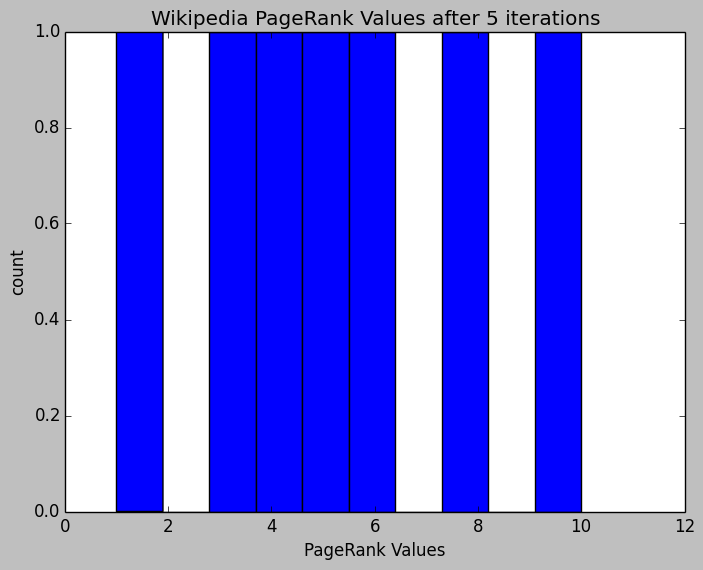

In [14]:
plt.hist([1, 3, 4, 5, 6, 8, 10])
plt.title("Wikipedia PageRank Values after 5 iterations")
plt.xlabel("PageRank Values")
plt.ylabel("count")
show(plt)

In [1]:
import os
import sys
#spark_home = os.environ['SPARK_HOME'] = '/Users/liang/Downloads/spark-1.4.1-bin-hadoop2.6/'
spark_home = os.environ['SPARK_HOME'] = 'C:\\spark-1.5.1-bin-hadoop2.4'

if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python', 'lib', 'py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python', 'pyspark', 'shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.1
      /_/

Using Python version 2.7.5 (default, Jul  1 2013 12:41:55)
SparkContext available as sc, HiveContext available as sqlContext.


# HW11.0  Broadcast versus Caching in Spark

... to add explaination on the difference between broadcasting and caching

In [16]:
# generate data
import numpy as np
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

Iteration0
[[ 0.65063694  0.68236631]
 [ 3.90278939  2.61822066]
 [ 2.26027557  5.78619402]]


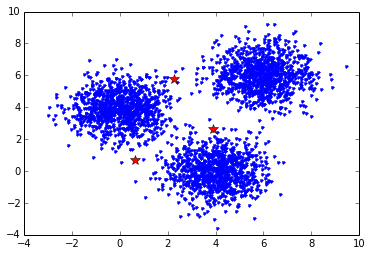

Iteration1
[[ 0.95890057  1.58112756]
 [ 5.05386286  1.93436863]
 [ 2.95825398  5.59431669]]


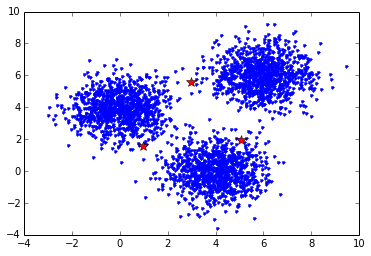

Iteration2
[[ 0.43387771  2.71298057]
 [ 4.76570132  0.80463859]
 [ 4.48135283  5.9685632 ]]


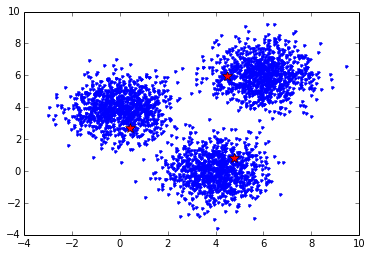

Iteration3
[[ 0.01688563  3.84742191]
 [ 4.06907157 -0.00896619]
 [ 5.89510728  6.04147129]]


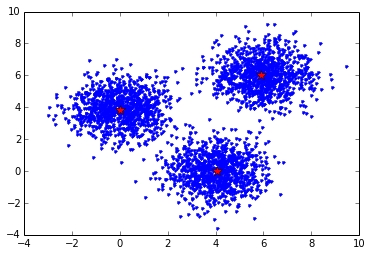

Iteration4
[[  2.60797518e-04   3.94806714e+00]
 [  4.00612354e+00  -3.09988645e-03]
 [  5.95821713e+00   6.03632785e+00]]


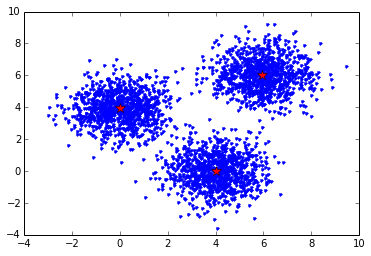

Iteration5
[[ -6.11227108e-04   3.95329581e+00]
 [  4.00197521e+00   5.43177150e-04]
 [  5.96119026e+00   6.03744988e+00]]


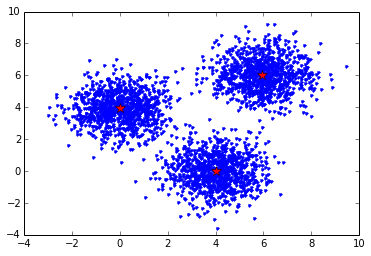

Final Results:
[[ -6.11227108e-04   3.95329581e+00]
 [  4.00197521e+00   5.43177150e-04]
 [  5.96119026e+00   6.03744988e+00]]


In [18]:
%matplotlib inline
import pylab 

# Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids_broadcasted.value)**2, axis=1).argmin() # use broadcasted centroid
    return (closest_centroid_idx,(x,1))

def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("data.csv").cache()
iter_num = 0
for i in range(10):
    centroids_broadcasted = sc.broadcast(centroids) # broadcast centroids before any distributed computing
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    if np.sum(np.absolute(centroids_new-centroids))<0.01:
        break
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    #plot_iteration(centroids)
print "Final Results:"
print centroids

# HW11.1  Loss Functions

... to do

# HW11.2 Gradient descent

In the context of logistic regression describe and define three flavors of penalized loss functions.  
Are these all supported in Spark MLLib (include online references to support your answers)?

Descibe probabilitic interpretations of the L1 and L2 priors for penalized logistic regression
(HINT: see synchronous slides for week 11 for details)

In the context of logistic regression, the three flavors of penalized terms are:
- L1 Reg, which penalizes for sum of absolute weights: $$l_{reg}(w) = \lambda \sum {|| w_i ||}$$
- L2 Reg, penalizes sum of squred weights: $$l_{reg}(w) = \lambda \sum {w_{i}^{2}}$$
- Elastic Net, penalizes a linear combination of L1 and L2 norms: $$\alpha\cdot||w|| + (1-\alpha)\cdot1/2\cdot||w||^2$$

All of the above three regularization methods are supported by spark.mllib:<br/>
http://spark.apache.org/docs/latest/mllib-linear-methods.html#regularizers

#### Probablisitic interpretation of L1 and L2 priors:

L1 regularization can be interpreted as using Laplace distribution as the prior distribution for the model weights, where as L2 regularization can be interpreted as using gaussian distribution as the prior distribution for the model weights.
<img src="http://people.ischool.berkeley.edu/~kuanlin/gaussian_vs_laplace.PNG">

The Laplace distribution has more density closer to mean (usually zero in most settings) in comparison to the gaussian distribution, and therefore L1 regularization will tend to push the model weights toward zero.

# HW11.3  Logistic Regression

Generate 2 sets of linearly separable data with 100 data points each using the data generation code
 provided below and plot each in separate plots. Call one the training set and the other the testing set.

In [42]:
import numpy as np
np.random.seed(0)
def generateData(n):
    """ 
    generates a 2D linearly separable dataset with n samples. 
    The third element of the sample is the label
    """
    xb = (np.random.normal(1,0.2,n)*2-1)/2-0.5
    yb = (np.random.normal(-1,0.2,n)*2-1)/2+0.5
    xr = (np.random.normal(1,0.2,n)*2-1)/2+0.5
    yr = (np.random.normal(-1,0.2,n)*2-1)/2-0.5
    inputs = []
    for i in range(len(xb)):
        inputs.append([xb[i],yb[i],1])
        inputs.append([xr[i],yr[i],-1])
    return inputs

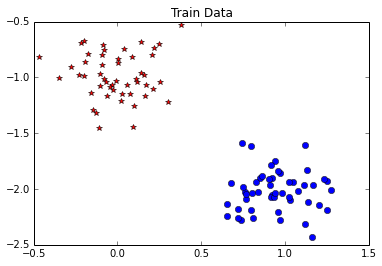

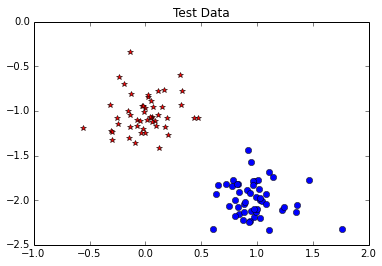

In [50]:
%matplotlib inline
import pylab

# generate 100 linearly seperatable data and plot them
data_lin_seperable_train = generateData(50) # train data
data_lin_seperable_test = generateData(50) # test data

pylab.plot([d[0] for d in data_lin_seperable_train if d[2]==1], [d[1] for d in data_lin_seperable_train if d[2]==1],'*', color = 'red')
pylab.plot([d[0] for d in data_lin_seperable_train if d[2]==-1], [d[1] for d in data_lin_seperable_train if d[2]==-1],'o', color = 'blue')
pylab.plt.title("Train Data")
pylab.show()
#show(pylab.plt)

pylab.plot([d[0] for d in data_lin_seperable_test if d[2]==1], [d[1] for d in data_lin_seperable_test if d[2]==1],'*', color = 'red')
pylab.plot([d[0] for d in data_lin_seperable_test if d[2]==-1], [d[1] for d in data_lin_seperable_test if d[2]==-1],'o', color = 'blue')
pylab.plt.title("Test Data")
pylab.show()
#show(pylab.plt)

Modify this data generation code to generating non-linearly separable training and testing datasets 
(with approximately 10% of the data falling on the wrong side of the separating hyperplane. Plot the resulting datasets. 

In [2]:
import numpy as np
def generateData2(n):
    """ 
    non-linearly seperable data
    """
    xb = (np.random.normal(5,0.5,n)*2-1)/2-0.5
    yb = (np.random.normal(-5,0.5,n)*2-1)/2+0.5
    xr = (np.random.normal(5,0.5,n)*2-1)/2+0.5
    yr = (np.random.normal(-5,0.5,n)*2-1)/2-0.5
    inputs = []
    for i in range(len(xb)):
        inputs.append([xb[i],yb[i],1])
        inputs.append([xr[i],yr[i],-1])
    return inputs

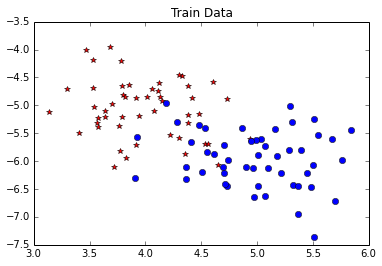

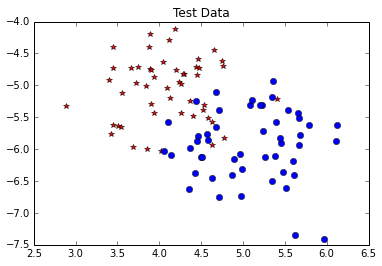

In [3]:
%matplotlib inline
import pylab

# generate 100 linearly seperatable data and plot them
data_lin_inseperable_train = generateData2(50) # train data
data_lin_inseperable_test = generateData2(50) # test data

pylab.plot([d[0] for d in data_lin_inseperable_train if d[2]==1], [d[1] for d in data_lin_inseperable_train if d[2]==1],'*', color = 'red')
pylab.plot([d[0] for d in data_lin_inseperable_train if d[2]==-1], [d[1] for d in data_lin_inseperable_train if d[2]==-1],'o', color = 'blue')
pylab.plt.title("Train Data")
pylab.show()
#show(pylab.plt)

pylab.plot([d[0] for d in data_lin_inseperable_test if d[2]==1], [d[1] for d in data_lin_inseperable_test if d[2]==1],'*', color = 'red')
pylab.plot([d[0] for d in data_lin_inseperable_test if d[2]==-1], [d[1] for d in data_lin_inseperable_test if d[2]==-1],'o', color = 'blue')
pylab.plt.title("Test Data")
pylab.show()
#show(pylab.plt)

NOTE: For the remainder of this problem please use the non-linearly separable training and testing datasets.

Using MLLib  train up a LASSO logistic regression model with the training dataset and evaluate with the testing set. 
What a good number of iterations for training the logistic regression model? Justify with plots and words. 

In [75]:
from pyspark.mllib.classification import LogisticRegressionWithSGD
#from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.regression import LabeledPoint

# convert data to an RDD of labeled points
def parsePoint(data):
    if data[2] == -1:
        label = 0
    else:
        label = 1
    return LabeledPoint(label, [data[0], data[1]])

train_data = sc.parallelize(data_lin_inseperable_train).map(parsePoint).cache()
test_data = sc.parallelize(data_lin_inseperable_test).map(parsePoint).cache()

test_metric_results = []
for iter_n in [10, 20, 40, 60, 80, 100, 120, 140, 160]:
    model = LogisticRegressionWithSGD.train(data=train_data, regType="l1", intercept=True,
                            miniBatchFraction=1.0, iterations=iter_n) # lasso regression
    predictionAndLabels = test_data.map(lambda lp: (float(model.predict(lp.features)), lp.label))
    #metrics = BinaryClassificationMetrics(predictionAndLabels)
    metrics = MulticlassMetrics(predictionAndLabels)
    precision = metrics.precision()
    recall = metrics.recall()
    f1Score = metrics.fMeasure()
    test_metric_results.append((iter_n, precision, recall, f1Score))
    print "Iter %s | Precision:%.4f | Recall:%.4f | F1:%.4f" %(iter_n, precision, recall, f1Score)


Iter 10 | Precision:0.5000 | Recall:0.5000 | F1:0.5000
Iter 20 | Precision:0.5000 | Recall:0.5000 | F1:0.5000
Iter 40 | Precision:0.5100 | Recall:0.5100 | F1:0.5100
Iter 60 | Precision:0.7600 | Recall:0.7600 | F1:0.7600
Iter 80 | Precision:0.7600 | Recall:0.7600 | F1:0.7600
Iter 100 | Precision:0.7600 | Recall:0.7600 | F1:0.7600
Iter 120 | Precision:0.7600 | Recall:0.7600 | F1:0.7600
Iter 140 | Precision:0.7500 | Recall:0.7500 | F1:0.7500
Iter 160 | Precision:0.7500 | Recall:0.7500 | F1:0.7500


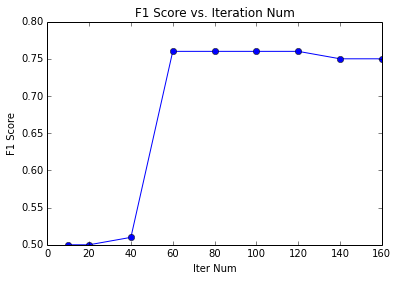

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([d[0] for d in test_metric_results], [d[3] for d in test_metric_results], '-o')
plt.title("F1 Score vs. Iteration Num")
plt.xlabel("Iter Num")
plt.ylabel("F1 Score")
plt.show()

Based on F1 score, the SGD implementation of LogisticRegression with L1 regularization seems to achieve its maximum around 60 iterations.  Increasing iteration number further does not seem to increase F1 score.

Derive and implement in Spark a weighted  LASSO logistic regression. Implement a convergence test of your choice to 
check for termination within your training algorithm . 

Weight the above training dataset as follows:  Weight each example using the inverse vector length (Euclidean norm): 

weight(X)= 1/||X||, 

where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

Here X is vector made up of X1 and X2.

Evaluate your homegrown weighted  LASSO logistic regression on the test dataset. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge.

Does Spark MLLib have a weighted LASSO logistic regression implementation. If so use it and report your findings on the weighted training set and test set.

In [12]:
from collections import namedtuple
import numpy as np
Point = namedtuple('Point', 'x y')

def readPoint(data):
    label = data[2]
    x = [data[0], data[1], 1.0]  #add bias term
    return Point(x, label)

def WeightedlogisticRegressionGD(data, wInitial=None, learningRate=0.05, iterations=10, regParam=0.01, regType=None, stopCriteria=0.0001):
    featureLen = len(data.take(1)[0].x)
    #n = data.count()
    total_weight = data.map(lambda p: (1.0/((p.x[0]**2+p.x[1]**2)**0.5))).reduce(lambda a,b: a+b)
    if wInitial is None:
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:
        w = wInitial
    for i in range(iterations):
        print "Iteration %s"%(i+1)
        wBroadcast = sc.broadcast(w)
        gradient = data.map(lambda p: (1.0/((p.x[0]**2+p.x[1]**2)**0.5))*(1 / (1 + np.exp(-p.y*np.dot(wBroadcast.value, p.x)))-1) * p.y * np.array(p.x))\
                    .reduce(lambda a, b: a + b)
        if regType == "Ridge":
            wReg = w * 1
            wReg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
        elif regType == "Lasso":
            wReg = w * 1
            wReg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
            wReg = (wReg>0).astype(int) * 2-1
        else:
            wReg = np.zeros(w.shape[0])
        gradient = gradient + regParam * wReg  #gradient:  GD of Sqaured Error+ GD of regularized term 
        wdelta = learningRate * gradient / total_weight # scale by total weight
        
        if sum(abs(wdelta))<=stopCriteria*sum(abs(w)): #Convergence condition
            print "convergenced reached at iteration %"%(i+1)
            break
        #w = w - learningRate * gradient / n
        w = w - wdelta
        print w
    return w

In [ ]:
train_data = sc.parallelize(data_lin_inseperable_train).map(readPoint).cache()
test_data = sc.parallelize(data_lin_inseperable_test).map(readPoint).cache()
w = WeightedlogisticRegressionGD(train_data, regType="Lasso", stopCriteria=0.001, iterations=100)
print "final weight:%s"%str(w)